In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [6]:
from keras import backend as K
from keras.engine.topology import Layer

In [7]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Concatenate
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras import objectives

In [8]:
class TradeGenerator:
    def __init__(self, count=10000):
        self.count = count

        self.spike_rate = 0.80 + 0.2*np.random.uniform()
        self.cycle_rate = 0.80 + 0.2*np.random.uniform()
        self.trend_rate = 0.80 + 0.2*np.random.uniform()
        self.trend_scale = 4.0
        
        self.value = 100
        self.ema = self.value
        self.trend = self.trend_scale * np.random.uniform()
        
    def __iter__(self):
        while self.count > 0:
            self.count -= 1
        
            self.value += np.random.normal() + self.trend

            # spike
            if np.random.uniform() > self.spike_rate:
                self.value += (np.random.uniform() - 0.5)*0.3 * self.value

            # cycling
            ratio = 0.95
            self.ema = ratio * self.ema + (1.0 - ratio) * self.value            
            if np.random.uniform() > self.cycle_rate:
                self.trend = (self.ema - self.value) / (np.random.uniform() * 20 + 10)
            
            # re-trending
            if np.random.uniform() > self.trend_rate:
                # trend change
                self.trend = self.trend_scale * np.random.normal() 
                
            if self.value <= 0.0:
                self.value = 1.0

            yield(self.value)        

In [24]:
def generate(sampleSize   =600,
             samplePast   =20,
             samplesFuture=5):

    sampleLength = samplePast + samplesFuture
    
    trades_past  = []
    x            = []
    y            = []
    trades_future= []
    
    for i in range(sampleSize):
        seq = np.array([i for i in TradeGenerator(count=sampleLength)])

        # normalize data to "now" point
        seq = seq / seq[samplePast]

        trades_past.append(seq[:samplePast])
        trades_future.append(seq[samplePast:])


            
    return np.array(trades_past), np.array(trades_future)

In [27]:
trades_past,trades_future = generate()

In [28]:
trades_past.shape,trades_future.shape

((600, 20), (600, 5))

In [31]:
inputDim  = trades_past.shape[1]
outputDim = trades_future.shape[1]

# network to learn the mixture params 
i = Input(shape=(inputDim,))
x = Dense(128)(i)
x = Activation('relu')(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(outputDim)(x)

model_train = Model(inputs=i, outputs=x)
model_train.summary()

opt = Adam(lr=0.001)
model_train.compile(loss='mse',optimizer=opt)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               2688      
_________________________________________________________________
activation_13 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_14 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_15 (Activation)   (None, 128)               0         
__________

In [32]:
hist = model_train.fit(trades_past, trades_future, batch_size=x_data.size, epochs=10000, verbose=1)

Epoch 1/10000
600/600 [==============================] - 0s 377us/step - loss: 3.5407
Epoch 2/10000
600/600 [==============================] - 0s 9us/step - loss: 2.0926
Epoch 3/10000
600/600 [==============================] - 0s 10us/step - loss: 1.3312
Epoch 4/10000
600/600 [==============================] - 0s 9us/step - loss: 1.0395
Epoch 5/10000
600/600 [==============================] - 0s 9us/step - loss: 1.0142
Epoch 6/10000
600/600 [==============================] - 0s 7us/step - loss: 1.0520
Epoch 7/10000
600/600 [==============================] - 0s 7us/step - loss: 1.0321
Epoch 8/10000
600/600 [==============================] - 0s 6us/step - loss: 0.9520
Epoch 9/10000
600/600 [==============================] - 0s 7us/step - loss: 0.8388
Epoch 10/10000
600/600 [==============================] - 0s 8us/step - loss: 0.7396
Epoch 11/10000
600/600 [==============================] - 0s 6us/step - loss: 0.6573
Epoch 12/10000
600/600 [==============================] - 0s 7us/step -

Epoch 98/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0479
Epoch 99/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0476
Epoch 100/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0472
Epoch 101/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0469
Epoch 102/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0466
Epoch 103/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0464
Epoch 104/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0461
Epoch 105/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0457
Epoch 106/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0454
Epoch 107/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0451
Epoch 108/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0447
Epoch 109/10000
600/600 [==============================

Epoch 194/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0255
Epoch 195/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0253
Epoch 196/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0252
Epoch 197/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0250
Epoch 198/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0248
Epoch 199/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0247
Epoch 200/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0246
Epoch 201/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0244
Epoch 202/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0243
Epoch 203/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0242
Epoch 204/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0242
Epoch 205/10000
600/600 [============================

Epoch 290/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0150
Epoch 291/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0142
Epoch 292/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0141
Epoch 293/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0147
Epoch 294/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0160
Epoch 295/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0169
Epoch 296/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0174
Epoch 297/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0151
Epoch 298/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0137
Epoch 299/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0152
Epoch 300/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0156
Epoch 301/10000
600/600 [=============================

Epoch 386/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0103
Epoch 387/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0100
Epoch 388/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0089
Epoch 389/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0088
Epoch 390/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0098
Epoch 391/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0118
Epoch 392/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0115
Epoch 393/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0105
Epoch 394/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0088
Epoch 395/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0093
Epoch 396/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0105
Epoch 397/10000
600/600 [=============================

Epoch 482/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0070
Epoch 483/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0073
Epoch 484/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0073
Epoch 485/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0074
Epoch 486/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0072
Epoch 487/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0068
Epoch 488/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0066
Epoch 489/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0068
Epoch 490/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0070
Epoch 491/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0069
Epoch 492/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0067
Epoch 493/10000
600/600 [=============================

Epoch 578/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0059
Epoch 579/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 580/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0061
Epoch 581/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 582/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0059
Epoch 583/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0058
Epoch 584/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0058
Epoch 585/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0059
Epoch 586/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0060
Epoch 587/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0059
Epoch 588/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0058
Epoch 589/10000
600/600 [=============================

Epoch 674/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0055
Epoch 675/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0058
Epoch 676/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0062
Epoch 677/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0061
Epoch 678/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0056
Epoch 679/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0054
Epoch 680/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0056
Epoch 681/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0058
Epoch 682/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0058
Epoch 683/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0056
Epoch 684/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0054
Epoch 685/10000
600/600 [=============================

Epoch 770/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0050
Epoch 771/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0050
Epoch 772/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0051
Epoch 773/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0051
Epoch 774/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0051
Epoch 775/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0051
Epoch 776/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0051
Epoch 777/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0051
Epoch 778/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0050
Epoch 779/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0050
Epoch 780/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0050
Epoch 781/10000
600/600 [============================

Epoch 866/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 867/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0048
Epoch 868/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 869/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 870/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 871/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 872/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 873/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 874/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0048
Epoch 875/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 876/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 877/10000
600/600 [=============================

600/600 [==============================] - 0s 8us/step - loss: 0.0056
Epoch 962/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0058
Epoch 963/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0067
Epoch 964/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0076
Epoch 965/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0085
Epoch 966/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0088
Epoch 967/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0079
Epoch 968/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0064
Epoch 969/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0050
Epoch 970/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0047
Epoch 971/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0053
Epoch 972/10000
600/600 [==============================] - 0s 11us/s

Epoch 1056/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0053
Epoch 1057/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0055
Epoch 1058/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0058
Epoch 1059/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0059
Epoch 1060/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0060
Epoch 1061/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0059
Epoch 1062/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0057
Epoch 1063/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0054
Epoch 1064/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0050
Epoch 1065/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0047
Epoch 1066/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 1067/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 1151/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 1152/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0050
Epoch 1153/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0049
Epoch 1154/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0045
Epoch 1155/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1156/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0045
Epoch 1157/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0047
Epoch 1158/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 1159/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0046
Epoch 1160/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0044
Epoch 1161/10000
600/600 [==============================] - 

Epoch 1245/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1246/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1247/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0045
Epoch 1248/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 1249/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 1250/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0045
Epoch 1251/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1252/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0044
Epoch 1253/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1254/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1255/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0043
Epoch 1256/10000
600/600 [=================

600/600 [==============================] - 0s 9us/step - loss: 0.0042
Epoch 1340/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 1341/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 1342/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0042
Epoch 1343/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0042
Epoch 1344/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0042
Epoch 1345/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0042
Epoch 1346/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 1347/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 1348/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0042
Epoch 1349/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 1350/10000
600/600 [==============================] - 

Epoch 1434/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 1435/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0041
Epoch 1436/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 1437/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 1438/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 1439/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 1440/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 1441/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 1442/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 1443/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 1444/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 1445/10000
600/600 [=================

600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 1529/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 1530/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 1531/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 1532/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 1533/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 1534/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 1535/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 1536/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 1537/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 1538/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 1539/10000
600/600 [==============================] - 

Epoch 1623/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0042
Epoch 1624/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0042
Epoch 1625/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0042
Epoch 1626/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0042
Epoch 1627/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 1628/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 1629/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 1630/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 1631/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 1632/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 1633/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 1634/10000
600/600 [================

600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 1718/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 1719/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0040
Epoch 1720/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 1721/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 1722/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0040
Epoch 1723/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0040
Epoch 1724/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0040
Epoch 1725/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 1726/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 1727/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 1728/10000
600/600 [==============================] - 

Epoch 1812/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 1813/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 1814/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 1815/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0039
Epoch 1816/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 1817/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 1818/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 1819/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 1820/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0039
Epoch 1821/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0039
Epoch 1822/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 1823/10000
600/600 [=================

Epoch 1907/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 1908/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0049
Epoch 1909/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0056
Epoch 1910/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0065
Epoch 1911/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0078
Epoch 1912/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0094
Epoch 1913/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0109
Epoch 1914/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0130
Epoch 1915/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0230
Epoch 1916/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0338
Epoch 1917/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0276
Epoch 1918/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 2002/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 2003/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 2004/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 2005/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 2006/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 2007/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0039
Epoch 2008/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 2009/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 2010/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 2011/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 2012/10000
600/600 [==============================] - 

Epoch 2096/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2097/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2098/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 2099/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2100/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2101/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 2102/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2103/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2104/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2105/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2106/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2107/10000
600/600 [=================

600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2191/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2192/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2193/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 2194/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2195/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2196/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2197/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 2198/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2199/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2200/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0038
Epoch 2201/10000
600/600 [==============================] - 

Epoch 2285/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2286/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2287/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0037
Epoch 2288/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2289/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2290/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2291/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 2292/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 2293/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2294/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2295/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2296/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2380/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0037
Epoch 2381/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 2382/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2383/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2384/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2385/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2386/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2387/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 2388/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2389/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 2390/10000
600/600 [==============================] - 

Epoch 2474/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 2475/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2476/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 2477/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2478/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 2479/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 2480/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 2481/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2482/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 2483/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2484/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2485/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 2569/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 2570/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 2571/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 2572/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 2573/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 2574/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 2575/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 2576/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 2577/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 2578/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 2579/10000
600/600 [==============================] - 

Epoch 2663/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2664/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 2665/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2666/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2667/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2668/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 2669/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2670/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 2671/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0037
Epoch 2672/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 2673/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 2674/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 2758/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 2759/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 2760/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0047
Epoch 2761/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0051
Epoch 2762/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0054
Epoch 2763/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0059
Epoch 2764/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0064
Epoch 2765/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0067
Epoch 2766/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0068
Epoch 2767/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0066
Epoch 2768/10000
600/600 [==============================] - 

Epoch 2852/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 2853/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 2854/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0036
Epoch 2855/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 2856/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 2857/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 2858/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 2859/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2860/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2861/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 2862/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0038
Epoch 2863/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 2947/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 2948/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 2949/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0051
Epoch 2950/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0053
Epoch 2951/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0063
Epoch 2952/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0055
Epoch 2953/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0043
Epoch 2954/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 2955/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0046
Epoch 2956/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0053
Epoch 2957/10000
600/600 [==============================] - 

Epoch 3041/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3042/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3043/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 3044/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3045/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 3046/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 3047/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3048/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 3049/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 3050/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 3051/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 3052/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 3136/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 3137/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 3138/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 3139/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 3140/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 3141/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 3142/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3143/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 3144/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 3145/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 3146/10000
600/600 [==============================] - 

Epoch 3230/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3231/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 3232/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0037
Epoch 3233/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 3234/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 3235/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 3236/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0035
Epoch 3237/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3238/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3239/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3240/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3241/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3325/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 3326/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 3327/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3328/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0034
Epoch 3329/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3330/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3331/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3332/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3333/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 3334/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 3335/10000
600/600 [==============================] - 

Epoch 3419/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 3420/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 3421/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 3422/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 3423/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 3424/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 3425/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0036
Epoch 3426/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3427/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3428/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 3429/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3430/10000
600/600 [================

600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3514/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3515/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3516/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3517/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3518/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3519/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3520/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3521/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3522/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3523/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3524/10000
600/600 [==============================] - 

Epoch 3608/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3609/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3610/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3611/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3612/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0034
Epoch 3613/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 3614/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3615/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3616/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3617/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3618/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3619/10000
600/600 [=================

600/600 [==============================] - 0s 9us/step - loss: 0.0034
Epoch 3703/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3704/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3705/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3706/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3707/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 3708/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3709/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3710/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 3711/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3712/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 3713/10000
600/600 [==============================] - 

Epoch 3797/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3798/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3799/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3800/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 3801/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 3802/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3803/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3804/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3805/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 3806/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3807/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3808/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3892/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 3893/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3894/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 3895/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 3896/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 3897/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 3898/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 3899/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 3900/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 3901/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0033
Epoch 3902/10000
600/600 [==============================] - 

Epoch 3986/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 3987/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3988/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 3989/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0033
Epoch 3990/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 3991/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 3992/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 3993/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 3994/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3995/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 3996/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 3997/10000
600/600 [================

600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4081/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 4082/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 4083/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4084/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4085/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 4086/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 4087/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 4088/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4089/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 4090/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 4091/10000
600/600 [==============================] - 

Epoch 4175/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 4176/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 4177/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4178/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4179/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 4180/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 4181/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4182/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 4183/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4184/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4185/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4186/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4270/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4271/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4272/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4273/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4274/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4275/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4276/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4277/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4278/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4279/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4280/10000
600/600 [==============================] - 

Epoch 4364/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4365/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4366/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4367/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4368/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4369/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4370/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4371/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4372/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0035
Epoch 4373/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4374/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4375/10000
600/600 [=================

600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4459/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4460/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4461/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4462/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0035
Epoch 4463/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4464/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4465/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4466/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4467/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4468/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4469/10000
600/600 [==============================] - 

Epoch 4553/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4554/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4555/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4556/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4557/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4558/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4559/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4560/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4561/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4562/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 4563/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 4564/10000
600/600 [=================

Epoch 4648/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 4649/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 4650/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4651/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4652/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 4653/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4654/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 4655/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4656/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4657/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4658/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4659/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 4743/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 4744/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4745/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 4746/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 4747/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4748/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4749/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4750/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 4751/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4752/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4753/10000
600/600 [==============================] - 

Epoch 4837/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4838/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4839/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 4840/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0037
Epoch 4841/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 4842/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 4843/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 4844/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 4845/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 4846/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 4847/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 4848/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 4932/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4933/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 4934/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 4935/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4936/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 4937/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0035
Epoch 4938/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4939/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4940/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4941/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 4942/10000
600/600 [==============================] - 

Epoch 5026/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0040
Epoch 5027/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0046
Epoch 5028/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 5029/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 5030/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 5031/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0042
Epoch 5032/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0043
Epoch 5033/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0039
Epoch 5034/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 5035/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0039
Epoch 5036/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 5037/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5121/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5122/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 5123/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5124/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5125/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5126/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5127/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5128/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5129/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5130/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 5131/10000
600/600 [==============================] - 

Epoch 5215/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5216/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5217/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5218/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5219/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5220/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0033
Epoch 5221/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5222/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5223/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5224/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 5225/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 5226/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 5310/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 5311/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0035
Epoch 5312/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 5313/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 5314/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0035
Epoch 5315/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0034
Epoch 5316/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 5317/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 5318/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5319/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5320/10000
600/600 [==============================] - 

Epoch 5404/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0057
Epoch 5405/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0084
Epoch 5406/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0096
Epoch 5407/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0053
Epoch 5408/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0063
Epoch 5409/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0085
Epoch 5410/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0046
Epoch 5411/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0058
Epoch 5412/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0066
Epoch 5413/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 5414/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0055
Epoch 5415/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5499/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5500/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5501/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5502/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5503/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5504/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0033
Epoch 5505/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5506/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5507/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5508/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5509/10000
600/600 [==============================] - 

Epoch 5593/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5594/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5595/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5596/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5597/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5598/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5599/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5600/10000
600/600 [==============================] - 0s 29us/step - loss: 0.0032
Epoch 5601/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 5602/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5603/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5604/10000
600/600 [================

600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5688/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5689/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5690/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 5691/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5692/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5693/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5694/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5695/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 5696/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5697/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5698/10000
600/600 [==============================] - 

Epoch 5782/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5783/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5784/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5785/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5786/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5787/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5788/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5789/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5790/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5791/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 5792/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 5793/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5877/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5878/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5879/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5880/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5881/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5882/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5883/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5884/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5885/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5886/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5887/10000
600/600 [==============================] - 

Epoch 5971/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 5972/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 5973/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 5974/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5975/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5976/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5977/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 5978/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 5979/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5980/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5981/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5982/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6066/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6067/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6068/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0031
Epoch 6069/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6070/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 6071/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 6072/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6073/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6074/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6075/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 6076/10000
600/600 [==============================] - 

Epoch 6160/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0031
Epoch 6161/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6162/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6163/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6164/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6165/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6166/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6167/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0031
Epoch 6168/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 6169/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0032
Epoch 6170/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 6171/10000
600/600 [===============

600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6255/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6256/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6257/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6258/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6259/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6260/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6261/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6262/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6263/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6264/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6265/10000
600/600 [==============================] - 

Epoch 6349/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6350/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6351/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6352/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6353/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6354/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6355/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6356/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6357/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6358/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6359/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6360/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6444/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 6445/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6446/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6447/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6448/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6449/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6450/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6451/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6452/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6453/10000
600/600 [==============================] - 0s 13us/step - loss: 0.0031
Epoch 6454/10000
600/600 [==============================] -

Epoch 6538/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0039
Epoch 6539/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 6540/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 6541/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 6542/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0036
Epoch 6543/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 6544/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 6545/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0036
Epoch 6546/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 6547/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 6548/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 6549/10000
600/600 [===============

600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6633/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 6634/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6635/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6636/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6637/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6638/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 6639/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 6640/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0033
Epoch 6641/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6642/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 6643/10000
600/600 [==============================] - 

Epoch 6727/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 6728/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 6729/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 6730/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6731/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6732/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6733/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 6734/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6735/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 6736/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6737/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 6738/10000
600/600 [=================

Epoch 6822/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 6823/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6824/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 6825/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 6826/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6827/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 6828/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 6829/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 6830/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6831/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 6832/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6833/10000
600/600 [=================

600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6917/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6918/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6919/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6920/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6921/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6922/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6923/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6924/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6925/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6926/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6927/10000
600/600 [==============================] - 

Epoch 7011/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7012/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7013/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7014/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7015/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7016/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7017/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7018/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7019/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7020/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7021/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7022/10000
600/600 [=================

600/600 [==============================] - 0s 9us/step - loss: 0.0031
Epoch 7106/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7107/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7108/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7109/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0031
Epoch 7110/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0031
Epoch 7111/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7112/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7113/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7114/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7115/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7116/10000
600/600 [==============================] - 

Epoch 7200/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7201/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7202/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7203/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7204/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7205/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7206/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7207/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7208/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0031
Epoch 7209/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7210/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7211/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7295/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7296/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7297/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7298/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7299/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7300/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7301/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7302/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7303/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7304/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7305/10000
600/600 [==============================] - 

Epoch 7389/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7390/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7391/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7392/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7393/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7394/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7395/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7396/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 7397/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 7398/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 7399/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 7400/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 7484/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 7485/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 7486/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 7487/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 7488/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 7489/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 7490/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 7491/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7492/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7493/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7494/10000
600/600 [==============================] - 

Epoch 7578/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7579/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7580/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7581/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7582/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0030
Epoch 7583/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7584/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7585/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7586/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7587/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7588/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7589/10000
600/600 [=================

600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7673/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7674/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7675/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7676/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7677/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7678/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7679/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7680/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7681/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7682/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7683/10000
600/600 [==============================] - 

Epoch 7767/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 7768/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7769/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 7770/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 7771/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7772/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 7773/10000
600/600 [==============================] - 0s 12us/step - loss: 0.0031
Epoch 7774/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7775/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7776/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7777/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7778/10000
600/600 [================

600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7862/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7863/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 7864/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 7865/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7866/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7867/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7868/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7869/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7870/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7871/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7872/10000
600/600 [==============================] - 

Epoch 7956/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7957/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7958/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7959/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7960/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7961/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 7962/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7963/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7964/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7965/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7966/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 7967/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8051/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 8052/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8053/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8054/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 8055/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8056/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 8057/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8058/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8059/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8060/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8061/10000
600/600 [==============================] - 

Epoch 8145/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8146/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8147/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8148/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8149/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8150/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8151/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8152/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8153/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8154/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 8155/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8156/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 8240/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 8241/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8242/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0030
Epoch 8243/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8244/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8245/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0029
Epoch 8246/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0029
Epoch 8247/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8248/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8249/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8250/10000
600/600 [==============================]

Epoch 8334/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8335/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8336/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 8337/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 8338/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8339/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 8340/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 8341/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8342/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8343/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8344/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8345/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8429/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8430/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8431/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 8432/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8433/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8434/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8435/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8436/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 8437/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 8438/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 8439/10000
600/600 [==============================] - 

Epoch 8523/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 8524/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 8525/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 8526/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 8527/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 8528/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0031
Epoch 8529/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8530/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8531/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8532/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8533/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8534/10000
600/600 [================

600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 8618/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8619/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8620/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8621/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0028
Epoch 8622/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 8623/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8624/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8625/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8626/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8627/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8628/10000
600/600 [==============================] - 

Epoch 8712/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8713/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 8714/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8715/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8716/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8717/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8718/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8719/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8720/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 8721/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8722/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 8723/10000
600/600 [=================

600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 8807/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 8808/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 8809/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 8810/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 8811/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 8812/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8813/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8814/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8815/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8816/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 8817/10000
600/600 [==============================] - 

Epoch 8901/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8902/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 8903/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8904/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8905/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 8906/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 8907/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 8908/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8909/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 8910/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 8911/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8912/10000
600/600 [=================

600/600 [==============================] - 0s 9us/step - loss: 0.0030
Epoch 8996/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8997/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8998/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8999/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9000/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9001/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 9002/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9003/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 9004/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 9005/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 9006/10000
600/600 [==============================] - 

Epoch 9090/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9091/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0028
Epoch 9092/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9093/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 9094/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 9095/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 9096/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 9097/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 9098/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 9099/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 9100/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 9101/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9185/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 9186/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 9187/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0028
Epoch 9188/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 9189/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 9190/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9191/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9192/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9193/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9194/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9195/10000
600/600 [==============================] - 

Epoch 9279/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 9280/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9281/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 9282/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 9283/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9284/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 9285/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 9286/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 9287/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 9288/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 9289/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9290/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9374/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9375/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9376/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9377/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9378/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0028
Epoch 9379/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9380/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 9381/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 9382/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 9383/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 9384/10000
600/600 [==============================] - 

Epoch 9468/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9469/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9470/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9471/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9472/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9473/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9474/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9475/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9476/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9477/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9478/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9479/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9563/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9564/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9565/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9566/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9567/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9568/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9569/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9570/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9571/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9572/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9573/10000
600/600 [==============================] - 

Epoch 9657/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9658/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 9659/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 9660/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 9661/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9662/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 9663/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9664/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9665/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9666/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9667/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9668/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9752/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9753/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0026
Epoch 9754/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9755/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9756/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9757/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9758/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9759/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9760/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9761/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9762/10000
600/600 [==============================] - 

Epoch 9846/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9847/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9848/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9849/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9850/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9851/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9852/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0026
Epoch 9853/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9854/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9855/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9856/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9857/10000
600/600 [=================

Epoch 9941/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9942/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9943/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9944/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9945/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9946/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 9947/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9948/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9949/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9950/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 9951/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 9952/10000
600/600 [=================

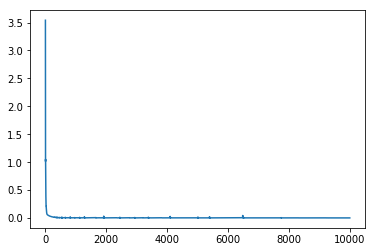

In [33]:
plt.plot(hist.history["loss"])

In [50]:
# TODO correct function params.. its using things not handed to it

def render(idxs):# now select a trade sequance and rennder its predictionn space
    for idx in idxs:
        past_selection = trades_past[idx:idx+1,:].flatten()
        past_x = np.arange(past_selection.shape[0])

        # trade_input = np.repeat(past_selection.reshape((1,-1)), np.prod(X.shape), axis=0)
        future_selection   = trades_future[idx:idx+1,:].flatten()
        future_x = np.arange(future_selection.shape[0]) + past_selection.shape[0]

        predict = model_train.predict(np.array(past_selection).reshape(1,-1)).flatten()

        fig, ax1 = plt.subplots(1,1, sharey=True, figsize=(20,7))

        ax1.plot(past_x   , past_selection, "r")
        ax1.plot(future_x , future_selection, "r")
        ax1.plot(future_x , predict, "b")
        plt.show()

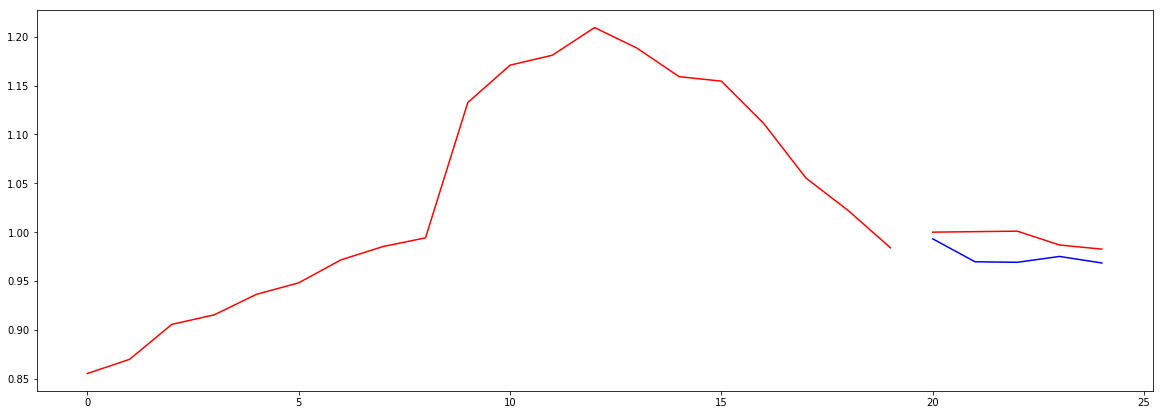

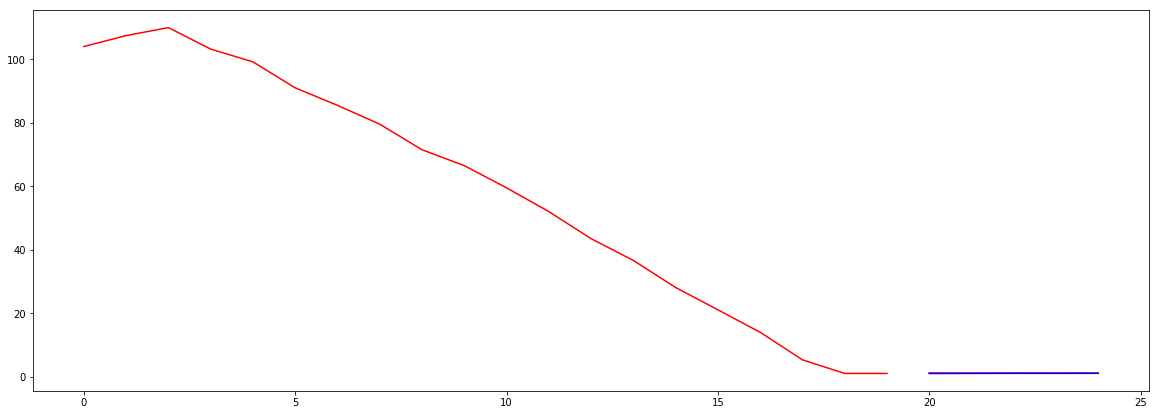

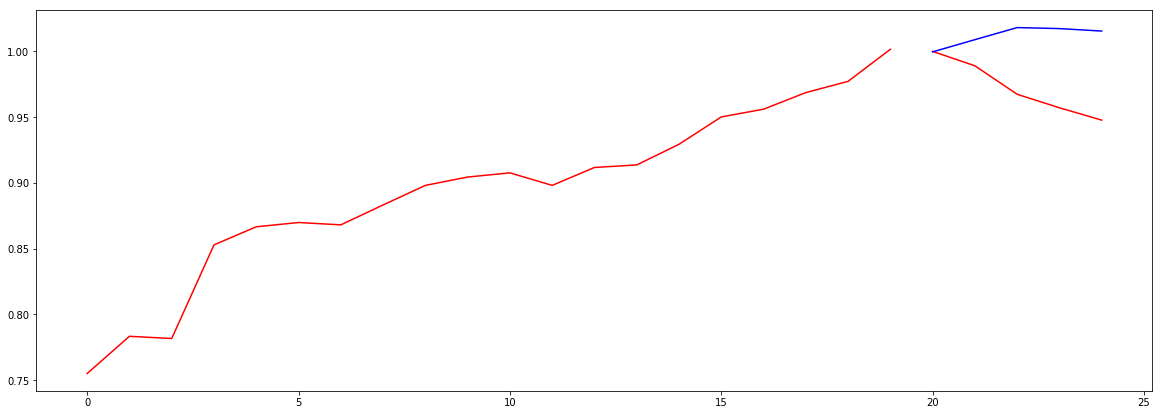

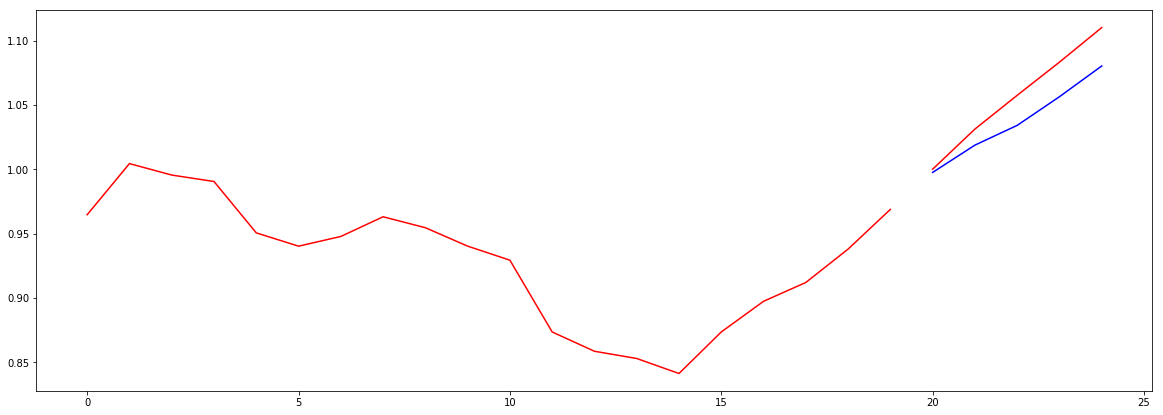

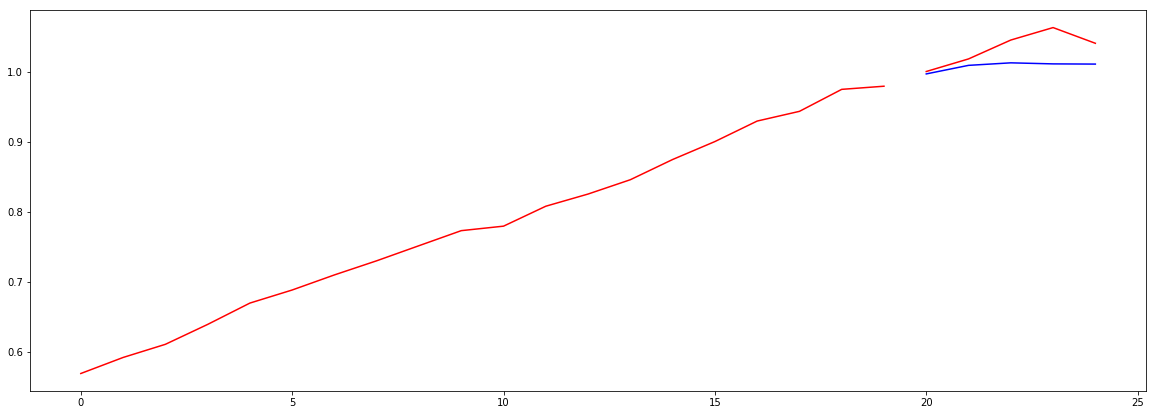

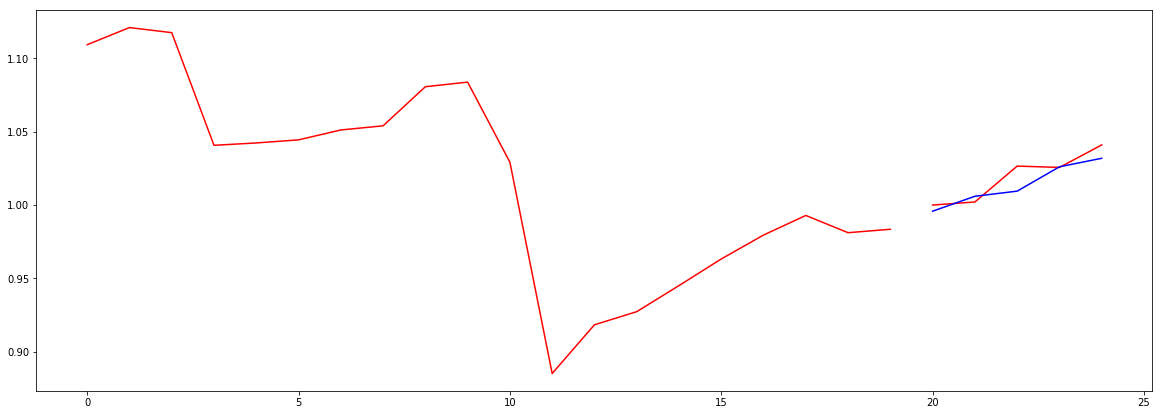

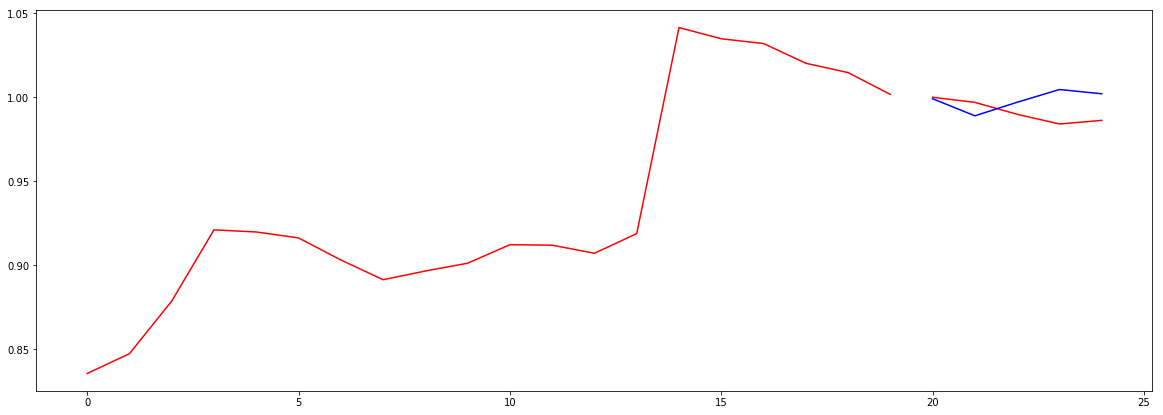

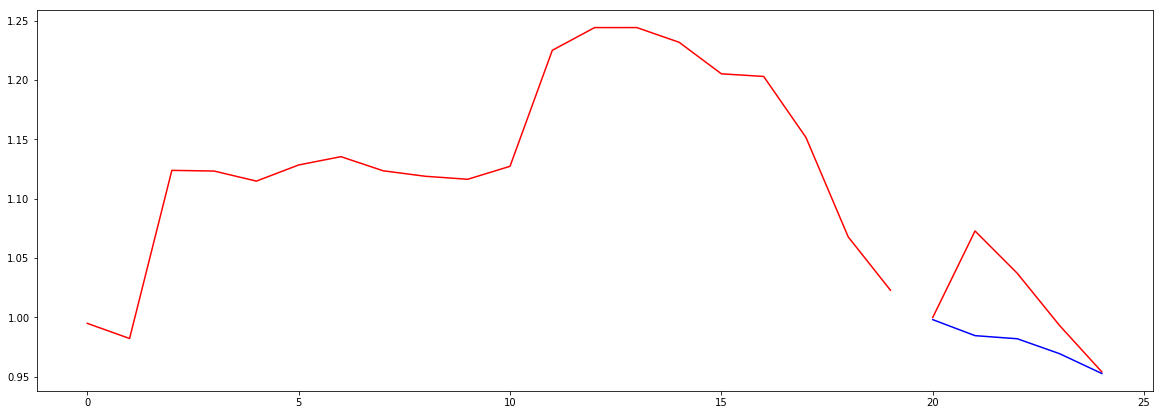

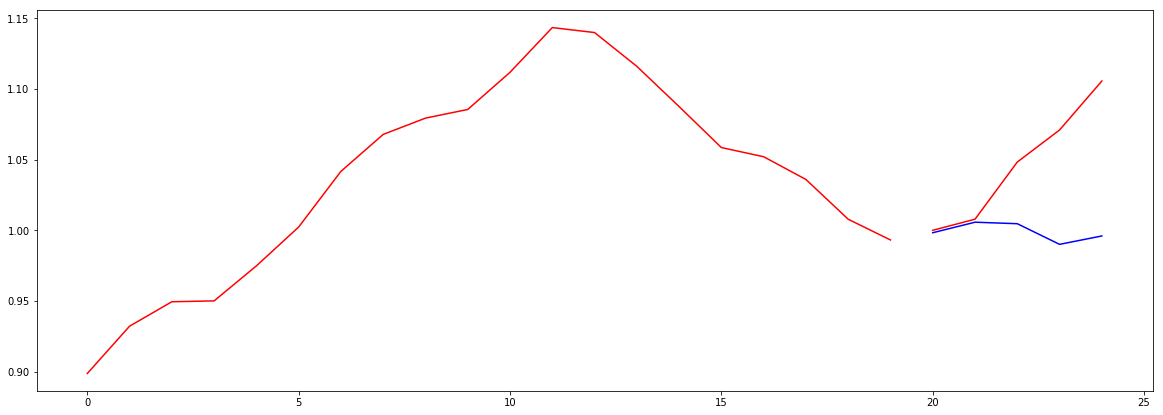

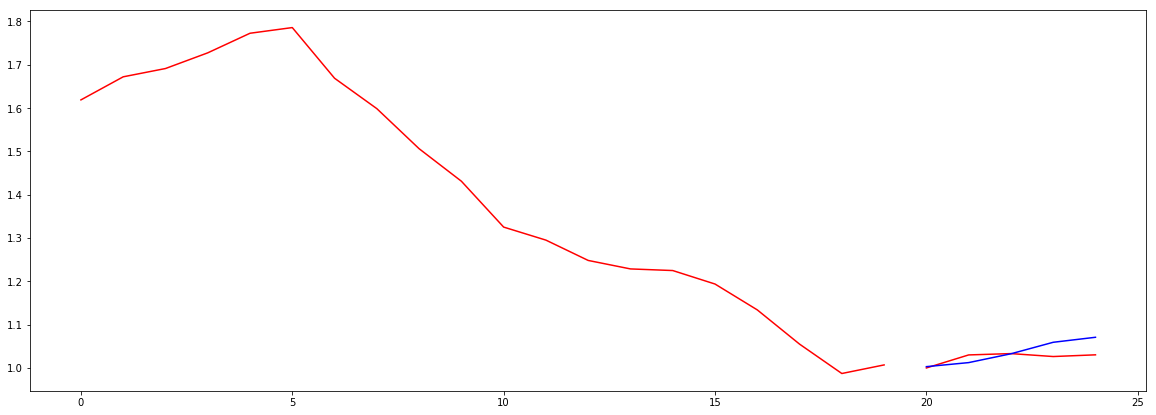

In [51]:
render(range(10))